In [1]:

import numpy as np
import pandas as pd
import re
import nltk
#import emoji
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import contractions

from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization, Concatenate
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
df_final = pd.read_excel('/content/FINAL_DATASET.xlsx')
df_final = df_final[['Translation', 'Corrected_Emotion']]
df_final.rename(columns={'Translation': 'text', 'Corrected_Emotion': 'main_category'}, inplace=True)
df_final.dropna(subset=['main_category'], inplace=True)
print("Final Evaluated shape:", df_final.shape)

df_go1 = pd.read_csv('/content/goemotions_1.csv')
df_go2 = pd.read_csv('/content/goemotions_2.csv')
df_go3 = pd.read_csv('/content/goemotions_3.csv')
df_go = pd.concat([df_go1, df_go2, df_go3], ignore_index=True)
print("GoEmotions shape:", df_go.shape)

emotion_cols = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
                'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
                'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
                'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization',
                'relief', 'remorse', 'sadness', 'surprise', 'neutral']
df_go['detailed'] = df_go[emotion_cols].idxmax(axis=1)

emotion_mapping = {
    "happiness": ["joy", "optimism", "approval", "pride", "gratitude", "excitement", "love", "amusement", "caring", "relief", "admiration"],
    "sadness": ["disappointment", "remorse", "grief", "sadness"],
    "anger": ["anger", "annoyance", "disapproval", "frustration"],
    "disgust": ["disgust"],
    "fear": ["fear", "nervousness"],
    "surprise": ["surprise", "realization"],
    "neutral": ["neutral"]
}
def map_to_main_category(detailed):
    for main_cat, subs in emotion_mapping.items():
        if detailed in subs:
            return main_cat
    return "neutral"
df_go['main_category'] = df_go['detailed'].apply(map_to_main_category)
df_go = df_go[['text', 'main_category']]

df_balanced = pd.concat([df_final, df_go], ignore_index=True)
df_balanced.dropna(subset=['main_category'], inplace=True)
print("Combined shape:", df_balanced.shape)

df_balanced.head(2)

Final Evaluated shape: (3855, 2)
GoEmotions shape: (211225, 37)
Combined shape: (215080, 2)


,text,main_category
0,Do you have a friend? No I do not have a friend.,neutral
1,"Do you want a single? Yes, I've been single fo...",neutral


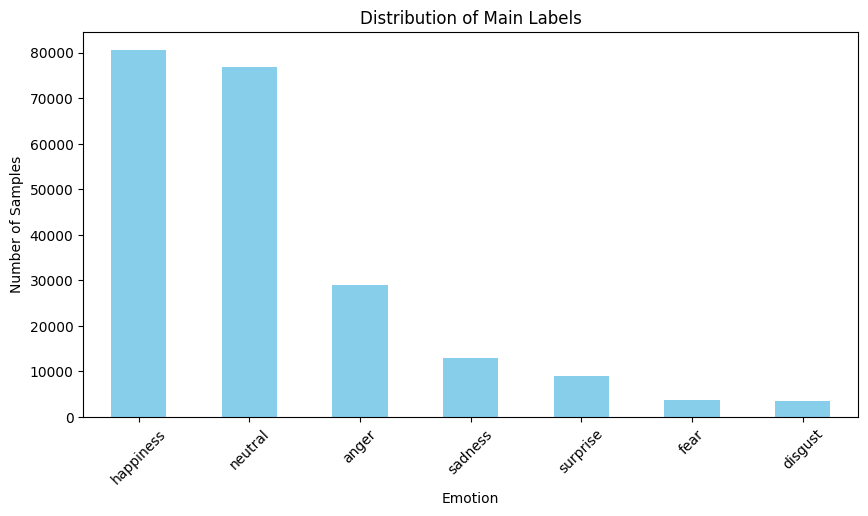

In [ ]:
import matplotlib.pyplot as plt

# Count the occurrences of each main_label category
label_counts = df_balanced['main_category'].value_counts()

# Plot distribution
plt.figure(figsize=(10, 5))
label_counts.plot(kind='bar', color='skyblue')
plt.title("Distribution of Main Labels")
plt.xlabel("Emotion")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# drop duplicates
df_balanced.drop_duplicates(subset=['text'], inplace=True)

print("Shape after removing duplicates:", df_balanced.shape)


Shape after removing duplicates: (60947, 2)


In [ ]:
# drop short sentences
df_balanced = df_balanced[df_balanced['text'].str.split().str.len() >= 5]
print("Shape after removing short sentences:", df_balanced.shape)

Shape after removing short sentences: (53520, 2)


In [ ]:
from parrot import Parrot
import pandas as pd
import random
from tqdm import tqdm
import numpy as np

# Load Parrot model (GPU enabled)
parrot = Parrot(model_tag="prithivida/parrot_paraphraser_on_T5", use_gpu=True)

# Augmentation parameters
SAMPLES_PER_CLASS = 2  # Augment each minority sample this many times
NUM_PARAPHRASES = 2  # Number of paraphrases to generate per text
THRESHOLD = 5000  # Augment only classes below this count
BATCH_SIZE = 50  # Number of sentences processed in one batch

# Get category distribution
category_counts = df_balanced["main_category"].value_counts()
print("Category distribution before augmentation:\n", category_counts)

# Identify minority classes
minority_classes = category_counts[category_counts < THRESHOLD].index.tolist()
print("Minority classes:", minority_classes)

# Filter minority class data
df_minority = df_balanced[df_balanced["main_category"].isin(minority_classes)].copy()

# Function to generate paraphrases (Batch processing)
def generate_paraphrases_batch(sentences, num_variations=NUM_PARAPHRASES):
    paraphrases_list = []
    for text in tqdm(sentences, desc="Generating paraphrases", leave=False):
        paraphrases = parrot.augment(input_phrase=text, use_gpu=True)
        paraphrases_list.append(paraphrases if paraphrases else [text])  # Ensure fallback
    return paraphrases_list

# Convert DataFrame rows into a list of sentences
sentences = df_minority["text"].tolist()
categories = df_minority["main_category"].tolist()

# Split into manageable batches
sentence_batches = [sentences[i:i + BATCH_SIZE] for i in range(0, len(sentences), BATCH_SIZE)]
category_batches = [categories[i:i + BATCH_SIZE] for i in range(0, len(categories), BATCH_SIZE)]

# Process batches with tqdm tracking
augmented_data = []
for batch, category_batch in tqdm(zip(sentence_batches, category_batches), total=len(sentence_batches), desc="Processing batches"):
    batch_paraphrases = generate_paraphrases_batch(batch)

    # Add paraphrases to dataset
    for original, para_list, category in zip(batch, batch_paraphrases, category_batch):
        for para in para_list[:SAMPLES_PER_CLASS]:  # Limit paraphrases per sample
            augmented_data.append({"text": para, "main_category": category})

# Convert to DataFrame
df_augmented = pd.DataFrame(augmented_data)

# Combine with original dataset
df_final_augmented = pd.concat([df_balanced, df_augmented], ignore_index=True)

print("Final dataset shape after augmentation:", df_final_augmented.shape)

# save document
df_final_augmented.to_csv("augmented_dataset.csv", index=False)


/usr/local/lib/python3.11/dist-packages/transformers/models/auto/tokenization_auto.py:823: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/models/auto/auto_factory.py:471: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Category distribution before augmentation:
 main_category
happiness    19765
neutral      19662
anger         6903
sadness       3153
surprise      2261
fear           976
disgust        800
Name: count, dtype: int64
Minority classes: ['sadness', 'surprise', 'fear', 'disgust']


Streaming output truncated to the last 5000 lines.
Processing batches: 100%|██████████| 144/144 [1:30:26<00:00, 37.68s/it]


Final dataset shape after augmentation: (63317, 2)


In [ ]:
df_balanced = df_final_augmented.copy()

In [ ]:
# drop duplicates
df_balanced.drop_duplicates(subset=['text'], inplace=True)

print("Shape after removing duplicates:", df_balanced.shape)

# drop short sentences
df_balanced = df_balanced[df_balanced['text'].str.split().str.len() >= 5]
print("Shape after removing short sentences:", df_balanced.shape)


Shape after removing duplicates: (62879, 2)
Shape after removing short sentences: (53520, 2)


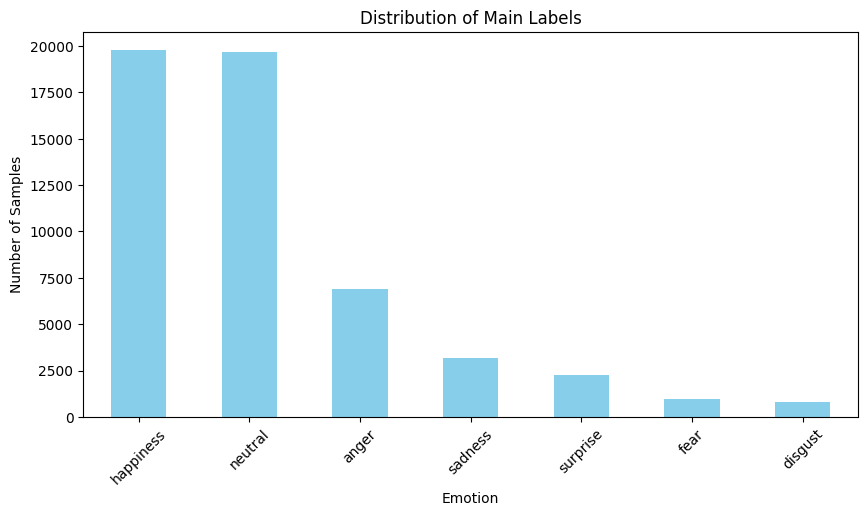

In [ ]:
# Count the occurrences of each main_label category
label_counts = df_balanced['main_category'].value_counts()

# Plot distribution
plt.figure(figsize=(10, 5))
label_counts.plot(kind='bar', color='skyblue')
plt.title("Distribution of Main Labels")
plt.xlabel("Emotion")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# ✅ Count class distribution
class_counts = df_balanced['main_category'].value_counts()
print("Original Class Distribution:\n", class_counts)

# ✅ Get minimum class size
min_class_size = class_counts.min()
print(f"Minimum Class Count: {min_class_size}")

# ✅ Balance all classes to the same size
df_balanced = df_balanced.groupby('main_category').apply(lambda x: x.sample(min_class_size, random_state=42)).reset_index(drop=True)

# ✅ Shuffle dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# ✅ Check new class distribution
print("Balanced Class Distribution:\n", df_balanced['main_category'].value_counts())


Original Class Distribution:
 main_category
happiness    19765
neutral      19662
anger         6903
sadness       3153
surprise      2261
fear           976
disgust        800
Name: count, dtype: int64
Minimum Class Count: 800
Balanced Class Distribution:
 main_category
sadness      800
fear         800
happiness    800
neutral      800
disgust      800
anger        800
surprise     800
Name: count, dtype: int64


<ipython-input-30-7aee19d0a79a>:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df_combined.groupby('main_category').apply(lambda x: x.sample(min_class_size, random_state=42)).reset_index(drop=True)


In [ ]:
def replace_emojis(text):
    """Convert emojis to their textual descriptions (without colons)."""
    # Convert emojis to text (default format: ":smiling_face_with_smiling_eyes:")
    demojized = emoji.demojize(text, delimiters=(" ", " "))
    demojized = demojized.replace(":", "").replace("_", " ")
    return demojized

def clean_text(text):
    text = replace_emojis(text) # emo
    text = text.lower() # low
    text = re.sub(r"http\S+|www\S+|https\S+", "", text) # link
    text = re.sub(r"@\w+|#\w+", "", text) # tags
    text = re.sub(r"[^a-zA-Z0-9'\[\].,!?]", " ", text) #
    text = ''.join([i for i in text if not i.isdigit()]) # digits
    text = re.sub(r'\[[^\]]*\]', '', text) # issue with name
    text = re.sub(r'(?<=\S)[.,](?=\S)', '', text)
    text = " ".join(text.split())
    text = re.sub(r'([.!?])\1+', r'\1', text)
    text = re.sub(r'(?<=\S)[.,](\s)', r'\1', text)
    text = re.sub(r'\d+(?:st|nd|rd|th)?', '', text)
    text = contractions.fix(text)

    return text

df_balanced['text'] = df_balanced['text'].astype(str).apply(clean_text)
df_balanced = df_balanced[df_balanced['text'].str.strip() != '']
print("Data shape after minimal cleaning:", df_balanced.shape)

df_balanced['text_length'] = df_balanced['text'].apply(lambda x: len(x.split()))
df_balanced = df_balanced[df_balanced['text_length'] >= 3]
df_balanced.drop(columns=['text_length'], inplace=True)
print("Shape after removing short texts:", df_balanced.shape)

Data shape after minimal cleaning: (53519, 2)
Shape after removing short texts: (53517, 2)


<ipython-input-31-ce7529ee9be0>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_combined['text_length'] = df_combined['text'].apply(lambda x: len(x.split()))


In [ ]:
# save document
df_balanced.to_csv("augmented_dataset_reduced.csv", index=False)

In [ ]:
text_counts = df_balanced['text'].value_counts()
print(text_counts.head(100))  # Top 20 repeated texts

text
desktop link r helperbot downvote to remove counter                                                                                         4
happy new year to you too!                                                                                                                  3
hey just noticed it is your th cakeday ! hug                                                                                                3
well my father yes go do it bye.                                                                                                            2
is that gone already? i do not know.                                                                                                        2
that is going to be a no from me dawg.                                                                                                      2
welcome to the party pal!                                                                                                                   2
i